In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import surp
import matplotlib.pyplot as plt
import vice
import numpy as np
from surp.gce_math import Z_to_MH, MH_to_Z, Z_SUN

from vice.yields.agb import interpolator

In [18]:
def plot_y_z(Zs, ele="c", kind="line", factor = 1, **kwargs):
    mass_yields = []
    
    for Z in Zs:
        m_c, times = vice.single_stellar_population(ele, Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 * factor

    if kind == "line":
        return plt.plot(Z_to_MH(Zs), y_c_agb, **kwargs)
    elif kind == "scatter":
        return plt.scatter(Z_to_MH(Zs), y_c_agb, **kwargs)

In [19]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 4.80e-02 (Z - Z0)   1.90 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model:  cristallo11
0.002850 + 0.029000 (Z-Zo)
f_agb = 0.2000




In [20]:
def y(Z=Z_SUN, ele="c"):
    m_c, times = vice.single_stellar_population(ele, Z=Z, mstar=1)
    return m_c[-1]

In [21]:
def y_agb(Z=Z_SUN, ele="c"):
    yc = vice.yields.ccsne.settings[ele]
    vice.yields.ccsne.settings[ele] = 0
    
    ya = y(Z)
    
    vice.yields.ccsne.settings[ele] = yc
    return ya

def y_cc(Z=Z_SUN, ele="c"):
    ya = vice.yields.agb.settings[ele]
    vice.yields.agb.settings[ele] = surp.yield_models.ZeroAGB()
    
    yc = y(Z)
    
    vice.yields.agb.settings[ele] = ya
    return yc

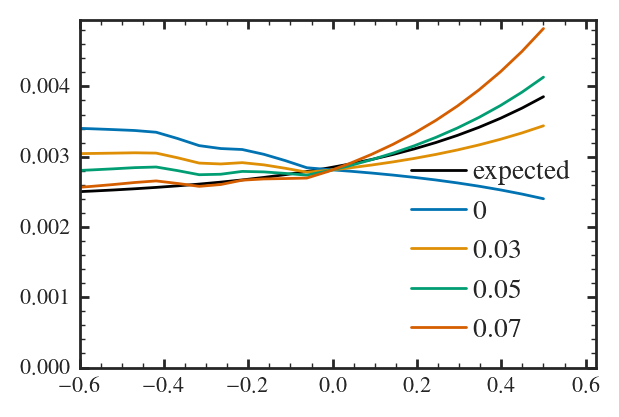

In [22]:
MH = np.linspace(-2, 0.5)
Zs = MH_to_Z(MH)

plt.plot(MH, surp.yields.y_c_total(Zs), label="expected", color="k")

for z_cc in [0, 0.03, 0.05, 0.07]:
    surp.yields.set_yields(f_agb=0.2, zeta_cc=z_cc, verbose=False,  agb_model="cristallo11")
    plot_y_z(Zs, label=z_cc)

plt.xlim(-0.6)
plt.ylim(0)
plt.legend()

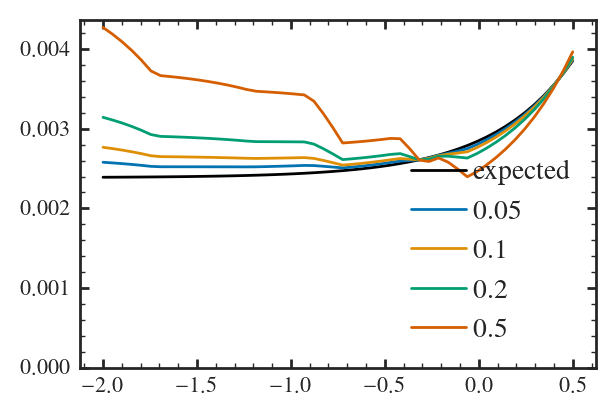

In [31]:
MH = np.linspace(-2, 0.5)
Zs = MH_to_Z(MH)

plt.plot(MH, surp.yields.y_c_total(Zs), label="expected", color="k")

for f in [0.05, 0.1, 0.2, 0.5]:
    surp.yields.set_yields(f_agb=f, verbose=False,  agb_model="cristallo11")
    plot_y_z(Zs, label=f)

plt.ylim(0)
plt.legend()

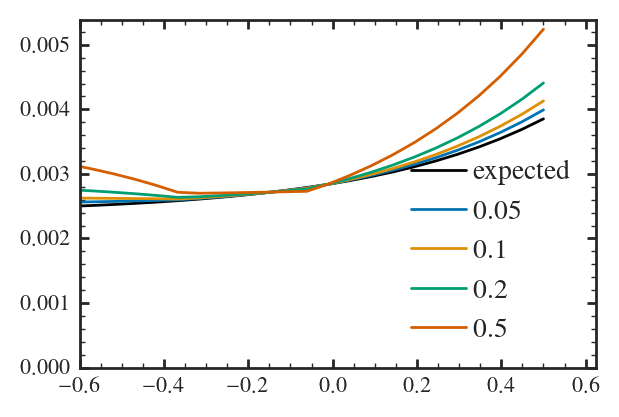

In [29]:
MH = np.linspace(-2, 0.5)
Zs = MH_to_Z(MH)

plt.plot(MH, surp.yields.y_c_total(Zs), label="expected", color="k")

for f in [0.05, 0.1, 0.2, 0.5]:
    surp.yields.set_yields(f_agb=f, verbose=False,  agb_model="karakas16")
    plot_y_z(Zs, label=f)

plt.xlim(-0.6)
plt.ylim(0)
plt.legend()

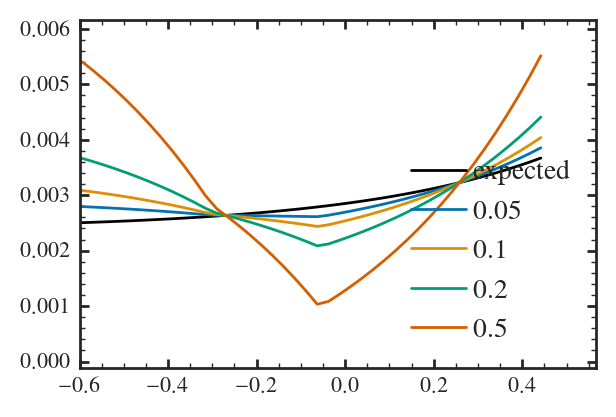

In [25]:
Zs = 0.014*np.logspace(-2, 0.5, 100)

plt.plot(Z_to_MH(Zs), surp.yields.y_c_total(Zs), label="expected", color="k")

for f in [0.05, 0.1, 0.2, 0.5]:
    surp.yields.set_yields(f_agb=f, verbose=False,  agb_model="ventura13")
    plot_y_z(Zs, label=f)

plt.xlim(-0.6)
plt.legend()

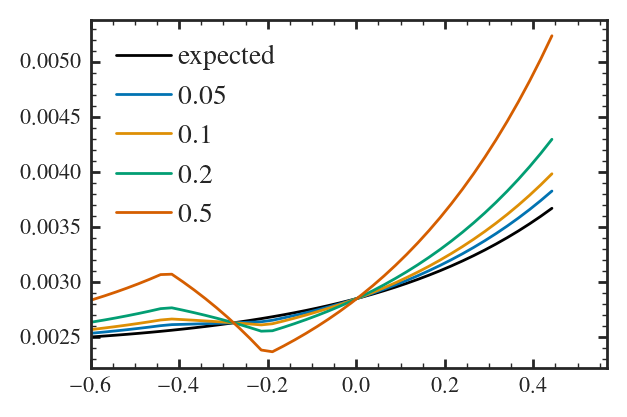

In [26]:
Zs = 0.014*np.logspace(-2, 0.5, 100)

plt.plot(Z_to_MH(Zs), surp.yields.y_c_total(Zs), label="expected", color="k")

for f in [0.05, 0.1, 0.2, 0.5]:
    surp.yields.set_yields(f_agb=f, verbose=False,  agb_model="pignatari16")
    plot_y_z(Zs, label=f)

plt.xlim(-0.6)
plt.legend()

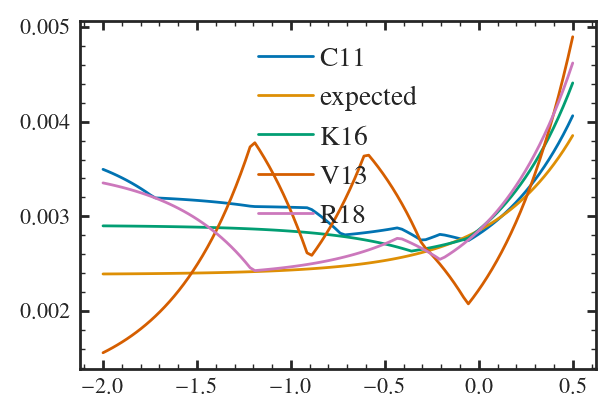

In [27]:
Zs = 0.016*np.logspace(-2, 0.5, 100)

surp.yields.set_yields(verbose=False)
plot_y_z(Zs, label="C11")
plt.plot(Z_to_MH(Zs), surp.yields.y_c_total(Zs), label="expected")


surp.yields.set_yields(agb_model="karakas16", verbose=False)
plot_y_z(Zs, label="K16")

surp.yields.set_yields(agb_model="ventura13", verbose=False)
plot_y_z(Zs, label="V13")


surp.yields.set_yields(agb_model="pignatari16", verbose=False)
plot_y_z(Zs, label="R18")
plt.legend()

In [13]:
surp.yields.set_yields(f_agb=1, yield_scale=1)#, agb_n_model="pignatari16")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   0.00e+00 + 1.18e-01 (Z - Z0)   8.91 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model:  cristallo11
0.002850 + 0.029000 (Z-Zo)
f_agb = 1.0000




In [14]:
MH = np.linspace(-2, 0.5)
Zs = MH_to_Z(MH)

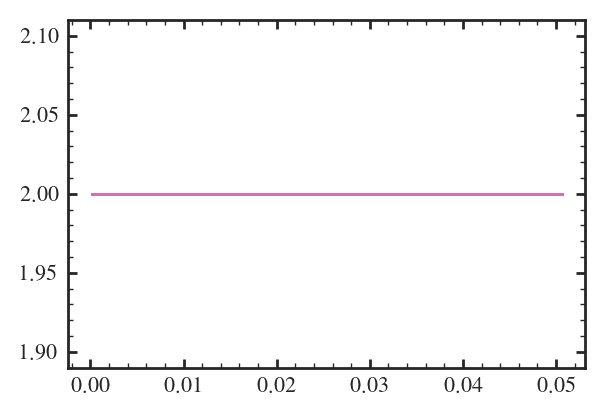

In [15]:
y1 = interpolator("c")
y2 = interpolator("c", prefactor=0.5)
for m in [1,2, 3, 5, 7]:
    plt.plot(Zs, [y1(m, Z)/y2(m, Z) for Z in Zs])


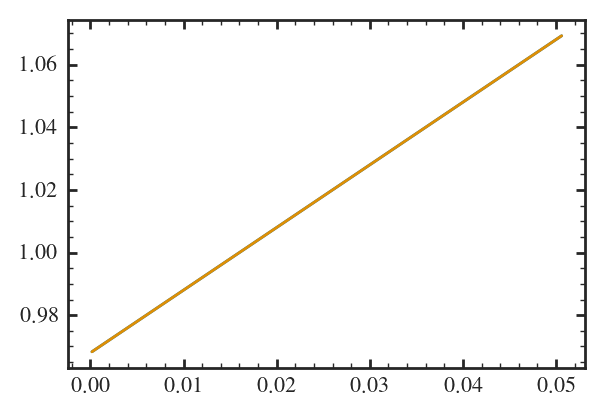

In [16]:
plt.plot(Zs, surp.yield_models.C_CC_Model(y0=1, zeta=2)(Zs))
plt.plot(Zs, 2*(Zs-0.016) + 1)

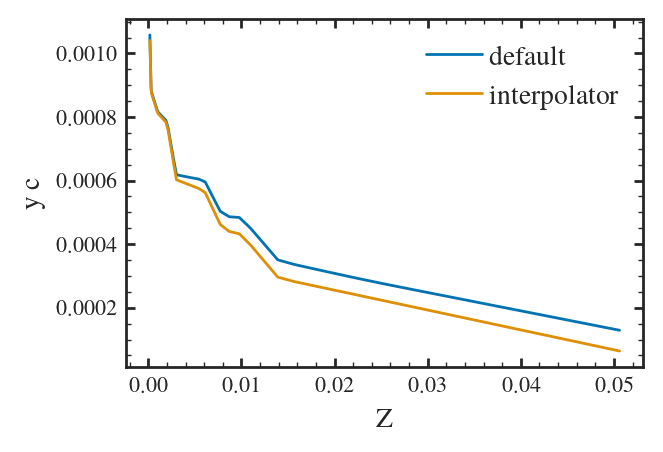

In [17]:
vice.yields.agb.settings["c"] = "cristallo11"
plt.plot(Zs, [y_agb(Z) for Z in Zs], label="default")

vice.yields.agb.settings["c"] = interpolator("c", no_negative=False)

plt.plot(Zs, [y_agb(Z)  for Z in Zs], label="interpolator")
plt.xlabel("Z")
plt.ylabel("y c")
plt.legend()